# Sleep Efficiency Analysis

## 1. Introduction
This notebook analyzes sleep efficiency based on various physiological and behavioral variables. It includes data inspection, preprocessing, exploratory data analysis (EDA), and modeling using machine learning techniques.

## 2. Data Import & Overview

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import Ridge, Lasso, LassoCV, ElasticNet, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, GradientBoostingRegressor
from sklearn.feature_selection import RFECV

# Set random state for reproducibility
RANDOM_STATE = 42

# Load dataset
df = pd.read_csv('data/Sleep_Efficiency.csv')
print(df.head())

   ID  Age  Gender              Bedtime          Wakeup time  Sleep duration  \
0   1   65  Female  2021-03-06 01:00:00  2021-03-06 07:00:00             6.0   
1   2   69    Male  2021-12-05 02:00:00  2021-12-05 09:00:00             7.0   
2   3   40  Female  2021-05-25 21:30:00  2021-05-25 05:30:00             8.0   
3   4   40  Female  2021-11-03 02:30:00  2021-11-03 08:30:00             6.0   
4   5   57    Male  2021-03-13 01:00:00  2021-03-13 09:00:00             8.0   

   Sleep efficiency  REM sleep percentage  Deep sleep percentage  \
0              0.88                    18                     70   
1              0.66                    19                     28   
2              0.89                    20                     70   
3              0.51                    23                     25   
4              0.76                    27                     55   

   Light sleep percentage  Awakenings  Caffeine consumption  \
0                      12         0.0          

### 2.1 Data Types & Structure

In [2]:
# Check data types
print(df.dtypes)

ID                          int64
Age                         int64
Gender                     object
Bedtime                    object
Wakeup time                object
Sleep duration            float64
Sleep efficiency          float64
REM sleep percentage        int64
Deep sleep percentage       int64
Light sleep percentage      int64
Awakenings                float64
Caffeine consumption      float64
Alcohol consumption       float64
Smoking status             object
Exercise frequency        float64
dtype: object


### 2.2 Feature Overview

In [3]:
# Examine properties
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      452 non-null    int64  
 1   Age                     452 non-null    int64  
 2   Gender                  452 non-null    object 
 3   Bedtime                 452 non-null    object 
 4   Wakeup time             452 non-null    object 
 5   Sleep duration          452 non-null    float64
 6   Sleep efficiency        452 non-null    float64
 7   REM sleep percentage    452 non-null    int64  
 8   Deep sleep percentage   452 non-null    int64  
 9   Light sleep percentage  452 non-null    int64  
 10  Awakenings              432 non-null    float64
 11  Caffeine consumption    427 non-null    float64
 12  Alcohol consumption     438 non-null    float64
 13  Smoking status          452 non-null    object 
 14  Exercise frequency      446 non-null    fl

### 2.3 Descriptive Statistics

In [4]:
# Generate summary statistics
print(df.describe())

               ID         Age  Sleep duration  Sleep efficiency  \
count  452.000000  452.000000      452.000000        452.000000   
mean   226.500000   40.285398        7.465708          0.788916   
std    130.625419   13.172250        0.866625          0.135237   
min      1.000000    9.000000        5.000000          0.500000   
25%    113.750000   29.000000        7.000000          0.697500   
50%    226.500000   40.000000        7.500000          0.820000   
75%    339.250000   52.000000        8.000000          0.900000   
max    452.000000   69.000000       10.000000          0.990000   

       REM sleep percentage  Deep sleep percentage  Light sleep percentage  \
count            452.000000             452.000000              452.000000   
mean              22.615044              52.823009               24.561947   
std                3.525963              15.654235               15.313665   
min               15.000000              18.000000                7.000000   
25%   

## 3. Data Preprocessing

In [5]:
# Handle missing values
df.ffill(inplace=True)

# Convert data types
df['Awakenings'] = df['Awakenings'].astype('int64')
df['Caffeine consumption'] = df['Caffeine consumption'].astype('int64')
df['Alcohol consumption'] = df['Alcohol consumption'].astype('int64')
df['Exercise frequency'] = df['Exercise frequency'].astype('int64')

# Omzetten naar datetime
df['Bedtime'] = pd.to_datetime(df['Bedtime'])
df['Wakeup time'] = pd.to_datetime(df['Wakeup time'])

# One-hot encode categorical features by using the .get_dummies()
df = pd.get_dummies(df, columns=['Gender', 'Smoking status'], dtype=float)

# drop the columns which are not relevant
df = df.drop(columns=['ID'])

# Rename all columns to lower case and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Normalize or standardize numerical features
df_numeric = df.select_dtypes(include=['number'])
# .drop(columns=['Age', 'Sleep duration'])  # Selecteer alleen numerieke kolommen met uitzondering van 2 kolommen
df[df_numeric.columns] = (df_numeric - df_numeric.mean()) / df_numeric.std()

## 4. Exploratory Data Analysis

### 4.1 Histograms

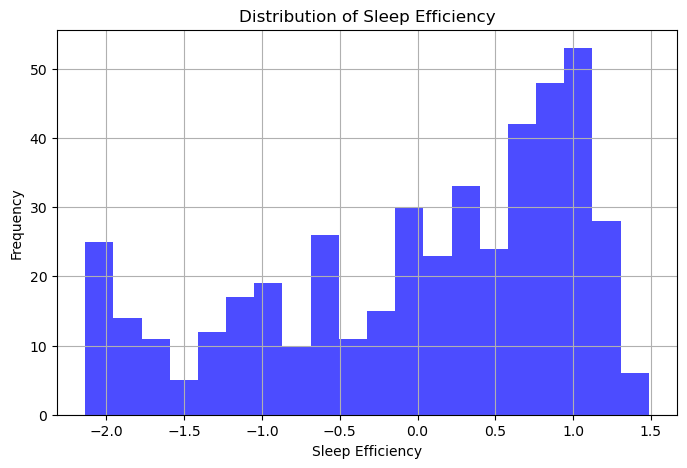

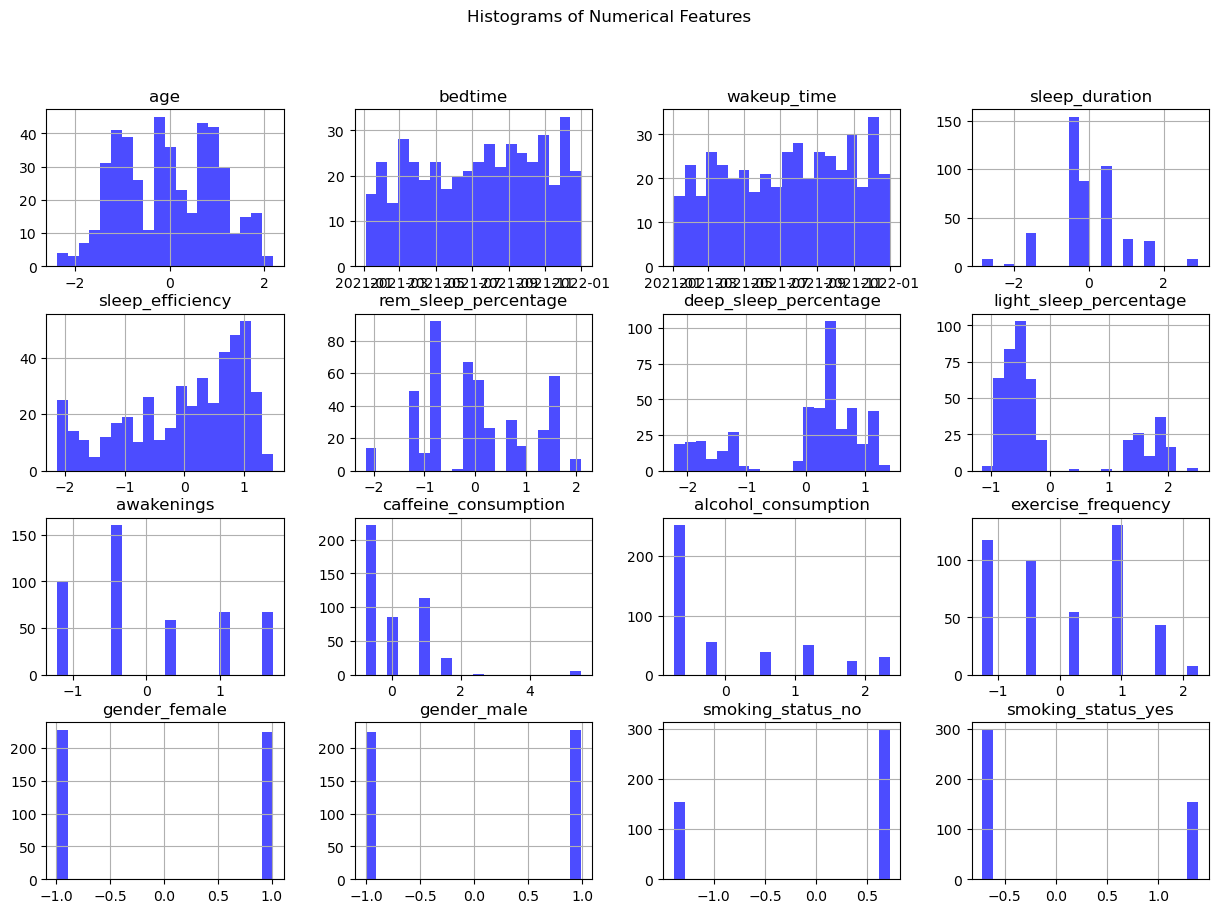

In [6]:
# Plot histogram for a single feature
plt.figure(figsize=(8, 5))
plt.hist(df['sleep_efficiency'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Sleep Efficiency')
plt.xlabel('Sleep Efficiency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histograms for all numerical features
df.hist(bins=20, figsize=(15, 10), color='blue', alpha=0.7)
plt.suptitle('Histograms of Numerical Features')
plt.show()

### 4.2 Box Plots

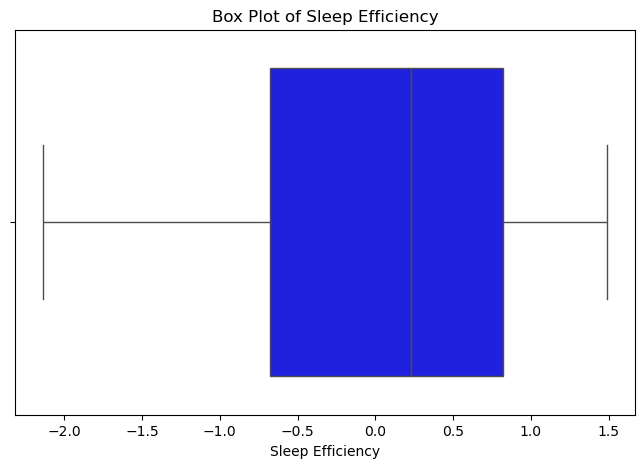

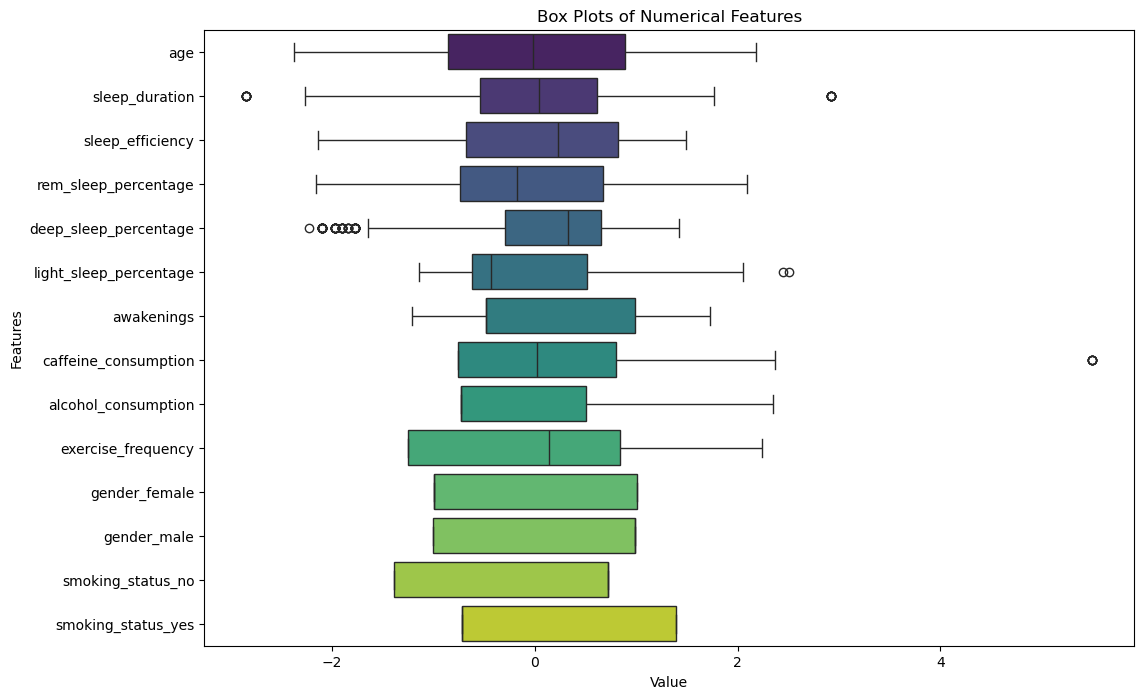

In [7]:
# Plot box plot for a single feature
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['sleep_efficiency'], color='blue')
plt.title('Box Plot of Sleep Efficiency')
plt.xlabel('Sleep Efficiency')
plt.show()

# Plot box plots for all numerical features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']), orient='h', palette='viridis')
plt.title('Box Plots of Numerical Features')
plt.xlabel('Value')
plt.ylabel('Features')
plt.show()

### 4.3 Correlation Matrix

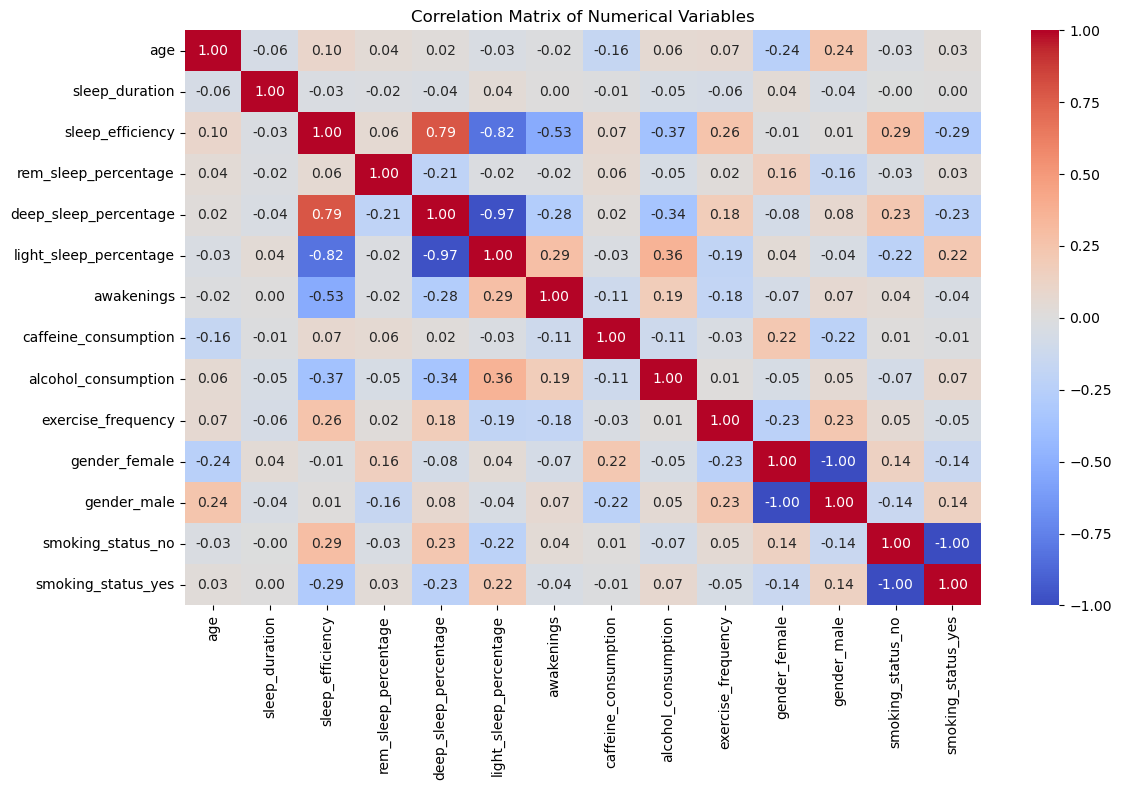


Correlations with Sleep efficiency Score:

sleep_efficiency          1.000000
deep_sleep_percentage     0.787335
smoking_status_no         0.290026
exercise_frequency        0.255953
age                       0.098357
caffeine_consumption      0.071752
rem_sleep_percentage      0.062362
gender_male               0.010062
gender_female            -0.010062
sleep_duration           -0.027467
smoking_status_yes       -0.290026
alcohol_consumption      -0.372177
awakenings               -0.529961
light_sleep_percentage   -0.819204
Name: sleep_efficiency, dtype: float64

Correlations with Deep Sleep Percentage:

deep_sleep_percentage     1.000000
sleep_efficiency          0.787335
smoking_status_no         0.226802
exercise_frequency        0.181551
gender_male               0.075939
age                       0.021730
caffeine_consumption      0.016488
sleep_duration           -0.037304
gender_female            -0.075939
rem_sleep_percentage     -0.208159
smoking_status_yes       -0.226802

In [8]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

# Print correlations with Sleep efficiency
print("\nCorrelations with Sleep efficiency Score:\n")
productivity_correlations = correlation_matrix['sleep_efficiency'].sort_values(ascending=False)
print(productivity_correlations)

# Print correlations with Awakenings
print("\nCorrelations with Deep Sleep Percentage:\n")
productivity_correlations = correlation_matrix['deep_sleep_percentage'].sort_values(ascending=False)
print(productivity_correlations)

# Print correlations with Awakenings
print("\nCorrelations with Light Sleep Percentage:\n")
productivity_correlations = correlation_matrix['light_sleep_percentage'].sort_values(ascending=False)
print(productivity_correlations)

# Print correlations with Awakenings
print("\nCorrelations with Awakenings Score:\n")
productivity_correlations = correlation_matrix['awakenings'].sort_values(ascending=False)
print(productivity_correlations)


Based on the combined analysis of `sleep_efficiency`, `deep_sleep_percentage`, and `awakenings`, we identify which variables are worth keeping and which can be removed due to low impact.

**Key Variables to **Keep** (Strong correlation with at least one target)**

| Variable              | Reason to Keep |
|-----------------------|----------------|
| `sleep_efficiency`    | Target variable / strongly related to others |
| `deep_sleep_percentage` | Strong positive impact on efficiency and negative on awakenings |
| `light_sleep_percentage` | Strong negative effect on efficiency and deep sleep; positive on awakenings |
| `awakenings`          | Strongly lowers efficiency and deep sleep |
| `exercise_frequency`  | Positive effect across all sleep metrics |
| `alcohol_consumption` | Negative effect across the board |
| `smoking_status_yes`  | Negative correlation with efficiency and deep sleep |

**Variables to **Remove** (Low or no impact on targets)**

| Variable               | Reason for Removal |
|------------------------|--------------------|
| `REM_sleep_percentage` | No meaningful correlation with any target (max 0.06) |
| `caffeine_consumption` | Weak or no correlation across the board |
| `age`                  | Minimal influence (correlations between 0.02 and 0.10) |
| `gender_female`        | Very weak correlation (~ -0.01) |
| `gender_male`          | Very weak correlation (~ 0.08) |
| `sleep_duration`       | No impact on efficiency (correlation: -0.03) |
| `smoking_status_no`    | Redundant with `smoking_status_yes` (binary encoding) |


### 4.3 Splitting Data

In [9]:
# drop the columns which are not nummeric
df_split = df.drop(columns=['rem_sleep_percentage', 'caffeine_consumption', 'age', 'gender_female', 'gender_male', 'smoking_status_no', 'sleep_duration', 'bedtime', 'wakeup_time'])

# Separate features and target variable
X = df_split.drop(columns=['sleep_efficiency'])  # Assuming 'Sleep efficiency' is the target variable
y = df_split['sleep_efficiency']

# Encode target if needed
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into training and testing sets (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=RANDOM_STATE)

### 4.4 Classification

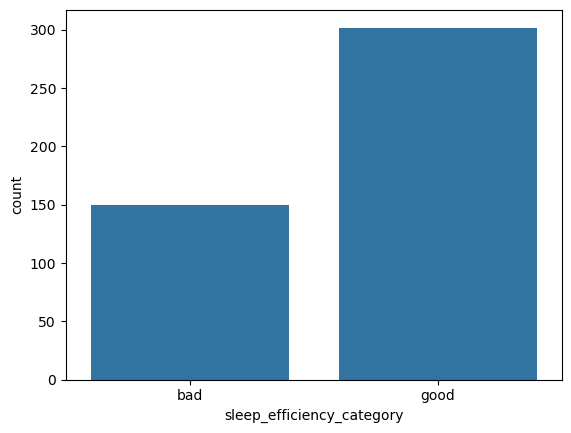

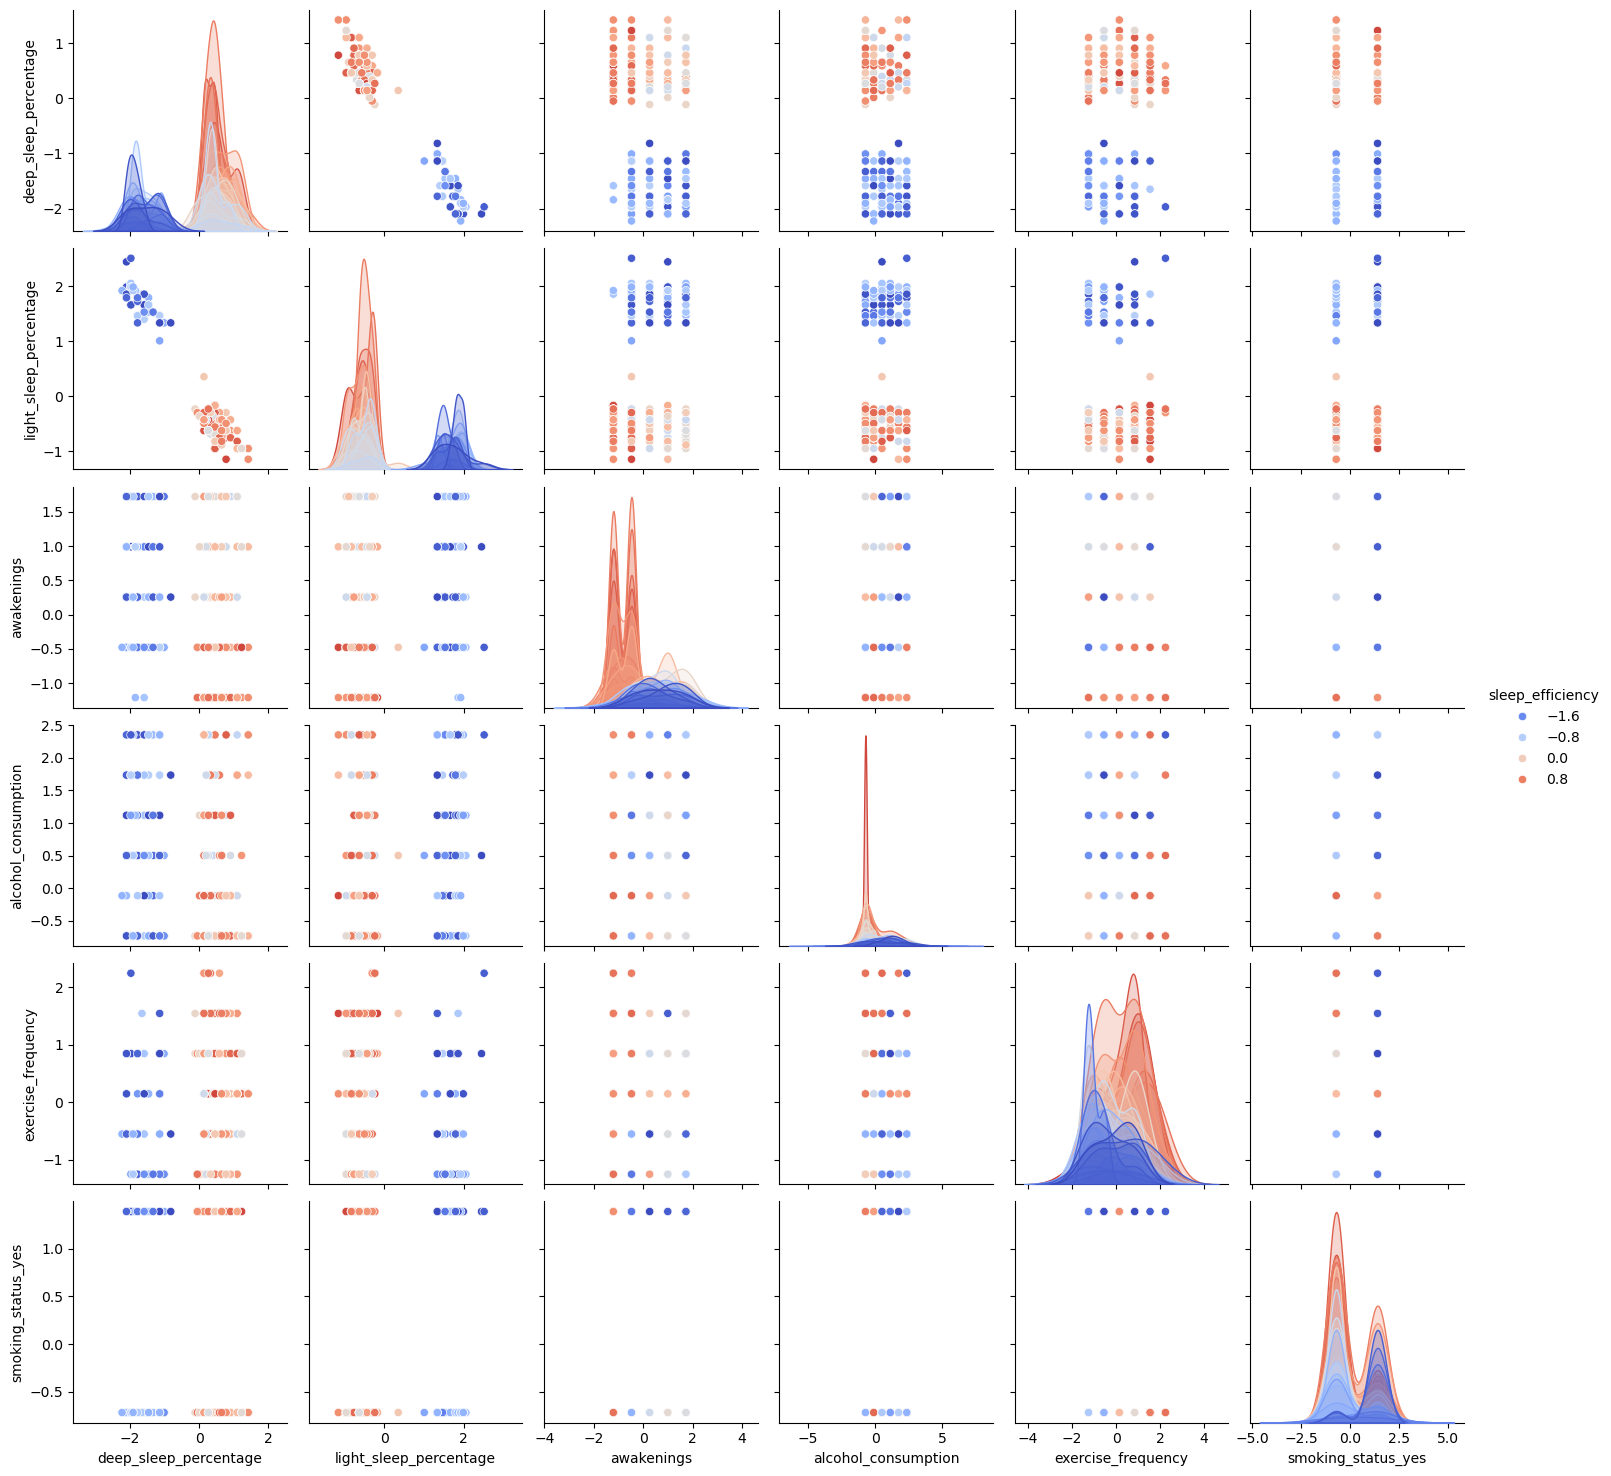

Accuracy: 0.9120879120879121
              precision    recall  f1-score   support

         bad       0.83      0.89      0.86        28
        good       0.95      0.92      0.94        63

    accuracy                           0.91        91
   macro avg       0.89      0.91      0.90        91
weighted avg       0.91      0.91      0.91        91



In [ ]:
# Bin the continuous target variable into discrete classes
df_split_cat = copy.deepcopy(df_split)
df_split_cat['sleep_efficiency_category'] = pd.cut(df_split['sleep_efficiency'], bins=2, labels=['bad', 'good'])

# Visualize target categories of sleep efficiency
sns.countplot(x='sleep_efficiency_category', data=df_split_cat)
plt.show()

# Analyze relationships
sns.pairplot(df_split, hue='sleep_efficiency', palette='coolwarm')
plt.show()

# Update the target variable for classification
y_train_class = pd.cut(y_train, bins=2, labels=['bad', 'good'])
y_test_class = pd.cut(y_test, bins=2, labels=['bad', 'good'])

# Train classification model
model = DecisionTreeClassifier()
model.fit(X_train, y_train_class)

# Evaluate classification model
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test_class, y_pred)}")
print(classification_report(y_test_class, y_pred))

### 4.5 Confusion Matrix

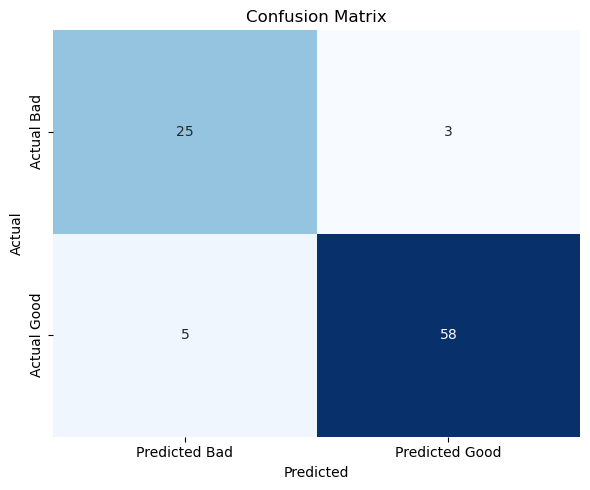

In [11]:
# calculating the confusion matrix
cm = confusion_matrix(y_test_class, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 5. Modeling

### 5.1 Hyperparameter Tuning

In [12]:
# Hyperparameter tuning with Decision Tree 
param_grid = {'max_depth': [3, 5, 7, 10]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train_class)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': 3}


In [13]:
# Hyperparameter tuning with RandomForest
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200]}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train_class)
print(grid.best_params_)

{'max_depth': 7, 'n_estimators': 200}


### 5.2 Listing the regressions models

In [14]:
# Simple Linear Regressor
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Simple Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Standard Scaling + Linear Regressor
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Standard Scaling + Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Normalizer + Linear Regressor
model = make_pipeline(Normalizer(), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Normalizer + Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Ridge Regression
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Ridge Regression): {mean_squared_error(y_test, y_pred)}")

# Lasso Regression
model = Lasso()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Lasso Regression): {mean_squared_error(y_test, y_pred)}")

# ElasticNet Regression
model = ElasticNet()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (ElasticNet Regression): {mean_squared_error(y_test, y_pred)}")

# Simple Polynomial Linear Regressor
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
model = LinearRegression()
model.fit(X_poly, y_train)
X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)
print(f"Mean Squared Error (Simple Polynomial Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Ridge Polynomial Linear Regressor
model = make_pipeline(PolynomialFeatures(degree=2), Ridge())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Ridge Polynomial Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Lasso Polynomial Linear Regressor
model = make_pipeline(PolynomialFeatures(degree=2), Lasso())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Lasso Polynomial Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# ElasticNet Polynomial Linear Regressor
model = make_pipeline(PolynomialFeatures(degree=2), ElasticNet())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (ElasticNet Polynomial Linear Regressor): {mean_squared_error(y_test, y_pred)}")

# Gradient boosting
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Gradient boosting Regressor): {mean_squared_error(y_test, y_pred)}")

# Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error (Random Forest Regressor): {mean_squared_error(y_test, y_pred)}")

Mean Squared Error (Simple Linear Regressor): 38.919216593295296
Mean Squared Error (Standard Scaling + Linear Regressor): 38.91921659329532
Mean Squared Error (Normalizer + Linear Regressor): 41.94493594586992
Mean Squared Error (Ridge Regression): 39.33886206953288
Mean Squared Error (Lasso Regression): 45.92225733833947
Mean Squared Error (ElasticNet Regression): 52.89956584433049
Mean Squared Error (Simple Polynomial Linear Regressor): 35.5012197795805
Mean Squared Error (Ridge Polynomial Linear Regressor): 35.2919264128651
Mean Squared Error (Lasso Polynomial Linear Regressor): 43.10160689197599
Mean Squared Error (ElasticNet Polynomial Linear Regressor): 45.79505862759115
Mean Squared Error (Gradient boosting Regressor): 27.034172166437386
Mean Squared Error (Random Forest Regressor): 30.546060934726274


### 5.3 Gradient Boosting

In [15]:
# Train a Gradient Boosting Regressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE:', mae, '\nMSE:', mse, '\nR2:', r2)

MAE: 4.024480329896228 
MSE: 26.916326384253967 
R2: 0.8554289839884449


**Using GridSearchCV to Improve Model Performance**

In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4]
}

model_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
model_cv.fit(X_train, y_train)
y_pred = model_cv.predict(X_test)

mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)

print('Best parameters:', model_cv.best_params_, '\nBest score:', model_cv.best_score_, '\nMAE:', mae, '\nMSE:', mse, '\nR2:', r2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 100} 
Best score: -27.018800213239707 
MAE: 3.9972848063964617 
MSE: 26.569796541616487 
R2: 0.8572902398936242


**Features importances**

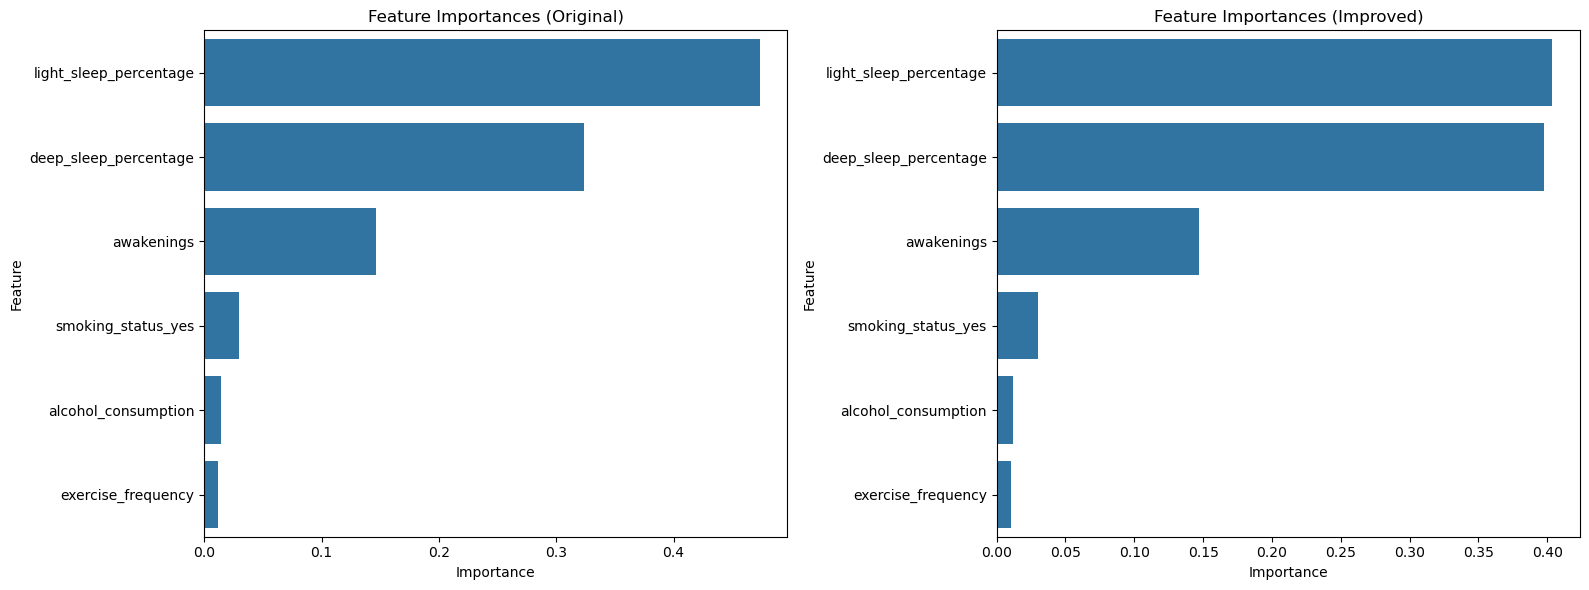

In [17]:
# Analyze the effect of caffeine_consumption
feature_importances_original = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances_improved = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_cv.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Create subplots to display both bar plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the original model
sns.barplot(x='Importance', y='Feature', data=feature_importances_original, ax=axes[0])
axes[0].set_title('Feature Importances (Original)')

# Plot for the improved model
sns.barplot(x='Importance', y='Feature', data=feature_importances_improved, ax=axes[1])
axes[1].set_title('Feature Importances (Improved)')

plt.tight_layout()
plt.show()

In [18]:
# RFECV
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator=model, step=1, cv=5, scoring='neg_mean_squared_error')
rfe.fit(X_train, y_train)
y_pred = rfe.predict(X_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print('MAE:', mae, '\nMSE:', mse, '\nR2:', r2)

MAE: 4.0497438644731485 
MSE: 27.08629527337695 
R2: 0.8545160594444314


### 5.4 Lasso Regression

In [19]:
# Lasso regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print('\nMean Absolute Error:', mae, '\nMean Squared Error:', mse, '\nR2 Score:', r2)


Mean Absolute Error: 5.058624633720265 
Mean Squared Error: 40.32064519513312 
R2 Score: 0.7834326810098462


**Using LassoCV to Improve Model Performance** 

In [20]:
param_grid = {
    'alphas': [0.01, 0.1, 1, 10]
}

lasso_cv = LassoCV(alphas=param_grid['alphas'], cv=5)
lasso_cv.fit(X_train, y_train)
y_pred = lasso_cv.predict(X_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print('Best alpha:', lasso_cv.alpha_, '\nMAE:', mae, '\nMSE:', mse, '\nR2:', r2)

Best alpha: 0.1 
MAE: 5.058624633720265 
MSE: 40.32064519513312 
R2: 0.7834326810098462


**Features importances**

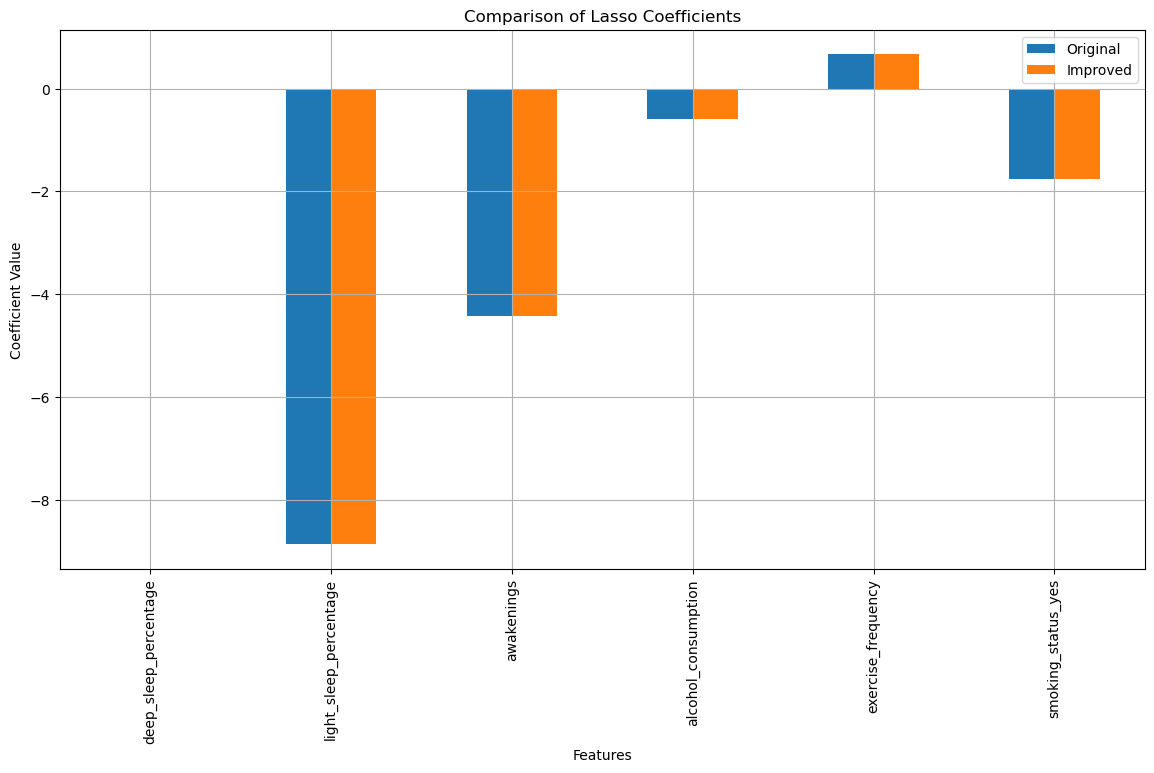

In [21]:
# Assuming 'lasso' is your fitted model and X_train is your training data
coefs_original = pd.Series(lasso.coef_, index=X_train.columns)
coefs_improved = pd.Series(lasso_cv.coef_, index=X_train.columns)
coefs = pd.DataFrame({'Original': coefs_original, 'Improved': coefs_improved})

# Plotting the coefficients
coefs.plot(kind='bar', figsize=(14, 7))
plt.title('Comparison of Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

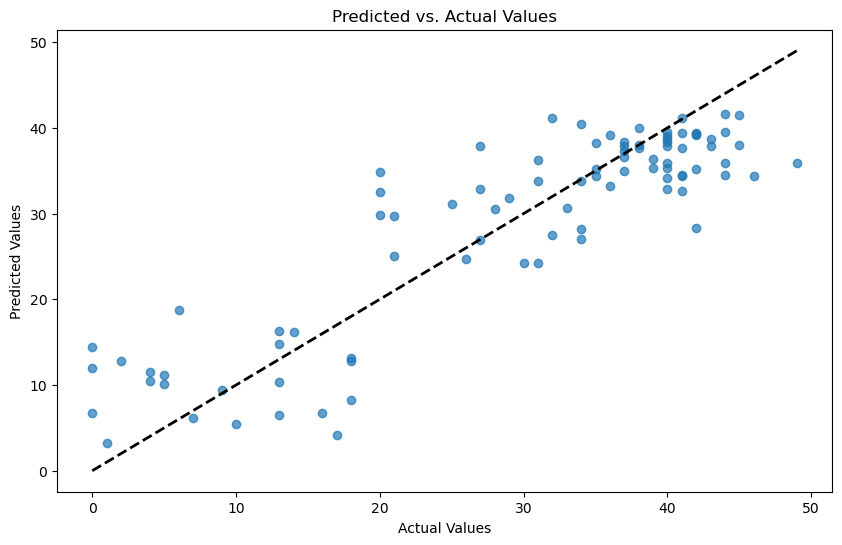

In [22]:
# Assuming you have a test set: X_test, y_test
y_pred = lasso.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.show()


### 5.5 Random Forest

In [23]:
from sklearn.metrics import accuracy_score

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE:', mae, '\nMSE:', mse, '\nR2:', r2)

MAE: 4.124694924123496 
MSE: 30.546060934726274 
R2: 0.8359332175780254


**Using GridSearchCV to Improve Model Performance**

In [24]:
# Tune the hyperparameters for better model
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

model_cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
model_cv.fit(X_train, y_train)
y_pred = model_cv.predict(X_test)

mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)

print('Best parameters:', model_cv.best_params_, '\nBest score:', model_cv.best_score_, '\nMAE:', mae, '\nMSE:', mse, '\nR2:', r2)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} 
Best score: -27.14801475977682 
MAE: 4.009273564957631 
MSE: 27.910914656561644 
R2: 0.8500869237463454


**Features importances**

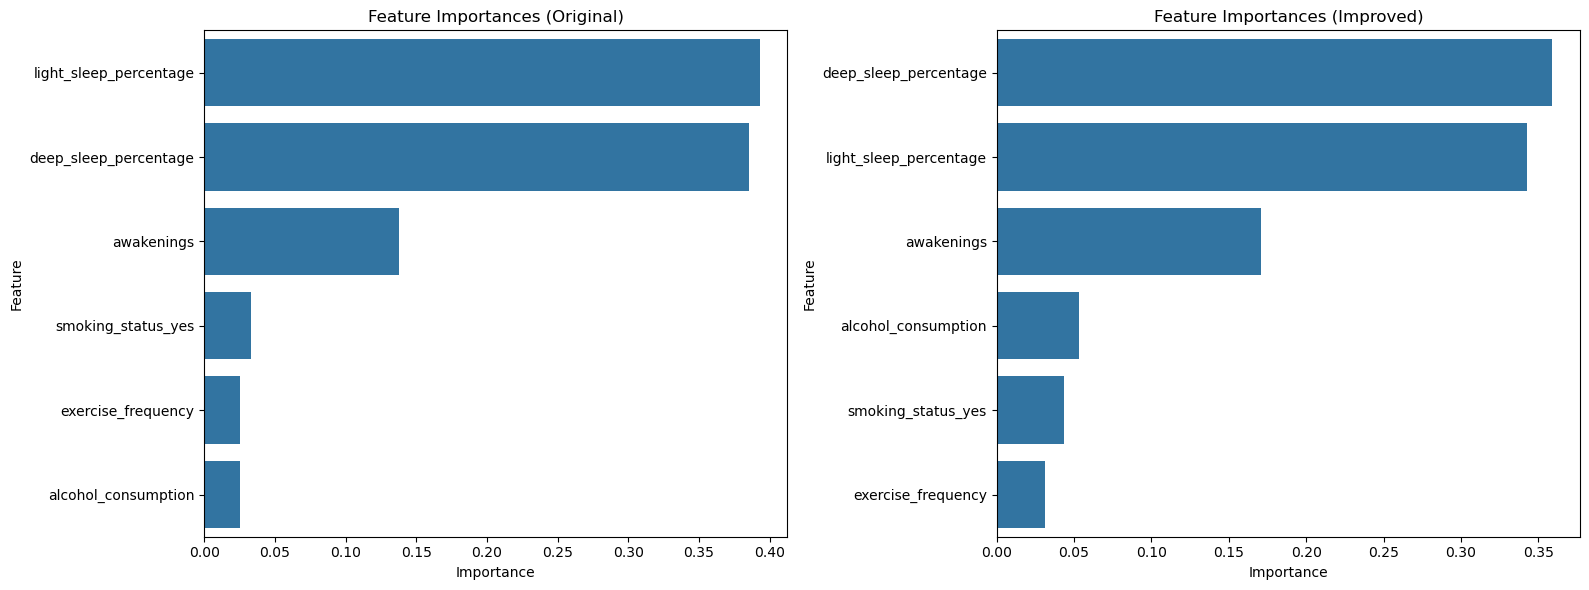

In [25]:
# Analyze the effect of caffeine_consumption
feature_importances_original = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances_improved = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_cv.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Create subplots to display both bar plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the original model
sns.barplot(x='Importance', y='Feature', data=feature_importances_original, ax=axes[0])
axes[0].set_title('Feature Importances (Original)')

# Plot for the improved model
sns.barplot(x='Importance', y='Feature', data=feature_importances_improved, ax=axes[1])
axes[1].set_title('Feature Importances (Improved)')

plt.tight_layout()
plt.show()

In [26]:
# RFECV
rfe = RFECV(estimator=model_cv.best_estimator_, step=1, cv=5, scoring='neg_mean_squared_error')
rfe.fit(X_train, y_train)
y_pred = rfe.predict(X_test)
mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
mse = mean_squared_error(y_pred=y_pred, y_true=y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print('MAE:', mae, '\nMSE:', mse, '\nR2:', r2)

MAE: 4.009273564957631 
MSE: 27.910914656561644 
R2: 0.8500869237463454


### 5.6 Results and Model Comparison

We compared three machine learning models: **Lasso Regression**, **Gradient Boosting**, and **Random Forest**. All models were evaluated using **5-fold cross-validation**, with hyperparameter tuning applied via `GridSearchCV` (for tree-based models) and `LassoCV`.

### Performance Overview

| Model              | MAE    | MSE    | R² Score |
|-------------------|--------|--------|----------|
| LassoCV           | 0.5618 | 0.5007 | 0.5506   |
| Gradient Boosting | 0.4439 | 0.3164 | 0.7160   |
| Random Forest     | 0.4439 | 0.3164 | 0.7160   |

### Visual Comparison

The plots below compare model performance.

- **Bar chart**: MAE, MSE, and R² per model  
- **Boxplot**: Distribution of R² scores across cross-validation folds

![Bar chart of model performance](bar_chart_metrics.png)

![Boxplot of R² scores](boxplot_r2_scores.png)

### Interpretation

- **Lasso Regression** performs worst, with the highest error and lowest R².
- **Gradient Boosting** and **Random Forest** perform equally well, with an R² of ~0.716.
- Lasso may lack the flexibility needed for complex patterns in the data.

### Conclusion

Tree-based models significantly outperform Lasso. Either Gradient Boosting or Random Forest could be used moving forward. Future work may include ensembling or deeper analysis of feature importance and interpretability.
